In [1]:
import numpy as np
import pandas as pd

# EDA
import matplotlib.pyplot as plt
import seaborn as sns

# Learning algorithms
import sklearn
from sklearn.linear_model import *
from sklearn.cluster import KMeans

# model validation
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

In [2]:
train_df=pd.read_csv('./Data_for_Modeling/Train_for_model.csv')
test_df=pd.read_csv('./Data_for_Modeling/Test_for_model.csv')
sub = pd.read_csv('sample_submission.csv')

In [3]:
# renaming columns
train_df.columns = ['num','datetime','target','temperature','windspeed','humidity','precipitation','insolation','nelec_cool_flag','solar_flag']
test_df.columns = ['num','datetime','target','temperature','windspeed','humidity','precipitation','insolation','nelec_cool_flag','solar_flag']

In [4]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4320 entries, 0 to 4319
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   num              4320 non-null   int64  
 1   datetime         4320 non-null   object 
 2   target           4320 non-null   float64
 3   temperature      4320 non-null   float64
 4   windspeed        4320 non-null   float64
 5   humidity         4320 non-null   int64  
 6   precipitation    4320 non-null   float64
 7   insolation       4320 non-null   float64
 8   nelec_cool_flag  4320 non-null   int64  
 9   solar_flag       4320 non-null   int64  
dtypes: float64(5), int64(4), object(1)
memory usage: 337.6+ KB


# Exploratory Data Analysis

In [5]:
eda_df = train_df.copy()

In [6]:
# adding features related to datetime
eda_df['datetime'] = pd.to_datetime(eda_df['datetime'])
eda_df['hour'] = eda_df['datetime'].dt.hour
eda_df['weekday'] = eda_df['datetime'].dt.weekday
eda_df['date'] = eda_df['datetime'].dt.date
eda_df['day'] = eda_df['datetime'].dt.day
eda_df['month'] = eda_df['datetime'].dt.month
eda_df['weekend'] = eda_df['weekday'].isin([5,6]).astype(int)

전력사용량은 사람의 행위에 의해 결정됩니다. 결국 전력을 사용하는 건 사람이기 때문입니다. 중요한 것은, 사람들이 **어떤** 요인으로 전력을 사용하는가 입니다. 대회에서 주어진 데이터를 기준으로, 크게 두 가지 요인을 생각해볼 수 있습니다. 

1. 시간 요인

오전 8시가 되어 사람들이 사무실로 출근하면 냉방을 위해 에어컨을 틀고, 오후 9시가 되어 주점이 오픈을 하면 다양한 전력 소모가 발생합니다. 주말이 되면 자연스레 사무실 전력사용량은 줄고, 카페나 식당 전력사용량은 증가합니다. 이 때, 사람들의 행위의 중요한 기준이 되는 변수가 시간(hour, weekday)입니다. 

2. 기상 요인

기상 또한 사람들의 행위에 중요한 영향을 미칩니다. 날씨가 덥고 불쾌지수가 높으면 에어컨을 켜고, 비가 오고 바람이 세게 불면 집 밖으로 잘 나가지 않는 등, 기상은 사람의 행위에 영향을 줌으로써 전력사용량에도 영향을 주게 됩니다.

위 두 가지 기준 **시간적 요인**,**기상적 요인** 을 중심으로 분석을 진행하겠습니다.

## 2.1. Energy Distribution

전력 사용량의 분포가 location, scale의 측면에서 건물마다 매우 다릅니다.

따라서, 건물번호를 one hot encoding으로 처리하거나, 건물 별로 별개의 모델을 만드는 방법에 대해 생각해 볼 수 있습니다.

## 2.2. energy usage of each building in relation to datetime
지금부터 datetime관련 변수(시간, 요일, 전체 timeline)에 따라 **건물별로** 전력사용량 패턴을 살펴보겠습니다.

### Energy usage in relation to weekday and hour

1. 건물별로 상이한 패턴이 보입니다. 대표적으로 아래 두 가지 패턴이 보입니다.
 * 평일 낮에만 전력사용량이 높은 건물
 * 평일 주말 상관없이 낮에만 전력사용량이 높은 건물


2. 건물 31, 33의 경우, 목요일 오후 5시에 공통적으로 전력사용량이 매우 낮게 나타납니다. 우선, 이 부분에 대해서 살펴 보겠습니다

건물 31,33에서 목요일 오후 5시에 전력수요 이상치를 확인했습니다. 단순한 이상치인지, 매주 목요일마다 나타나는 패턴인지 확인 해 보겠습니다.

In [9]:
num_31 = eda_df[eda_df.num == 31]
num_33 = eda_df[eda_df.num == 33]



In [10]:
print(num_31.loc[num_31.target < 4000, 'datetime'])
print(num_33.loc[num_33.target < 2000, 'datetime'])

15137   2020-06-11 17:00:00
Name: datetime, dtype: datetime64[ns]
15185   2020-06-11 17:00:00
Name: datetime, dtype: datetime64[ns]


건물 31, 33에서 발생한 outlier 가 정확히 같은 시간대에 발생한 것으로 볼 때, 두 건물은 지리적 혹은 다른 요인에 의해 유사성이 있는 것으로 보입니다.

일단 이상치인 것으로 판단하고, 모델링 시, 주변값의 평균으로 해당 이상치를 채우기로 결정했습니다.

### Clustering building based on median energy usage of each hour and weekday

앞에서 건물 별 heatmap visualization을 통해, 건물마다 상이한 혹은 유사한 전력사용 패턴을 확인해 보았습니다.

분석의 용의성을 위해, 비슷한 전력사용 양상을 보이는 건물끼리 군집화 해 보겠습니다.

In [11]:
# 건물을 기준으로 하는 data frame 생성
by_weekday = eda_df.groupby(['num','weekday'])['target'].median().reset_index().pivot('num','weekday','target').reset_index()
by_hour = eda_df.groupby(['num','hour'])['target'].median().reset_index().pivot('num','hour','target').reset_index().drop('num', axis = 1)
df = pd.concat([by_weekday, by_hour], axis= 1)
columns = ['num'] + ['day'+str(i) for i in range(7)] + ['hour'+str(i) for i in range(24)]
df.columns = columns

In [12]:
# '전력사용량'이 아닌 '요일과 시간대에 따른 전력 사용량의 경향성'에 따라서만 군집화 할 것이므로, 특수한 scaling이 필요함
# standard scaling
for i in range(len(df)):
    # 요일 별 전력 중앙값에 대해 scaling
    df.iloc[i,1:8] = (df.iloc[i,1:8] - df.iloc[i,1:8].mean())/df.iloc[i,1:8].std()
    # 시간대별 전력 중앙값에 대해 scaling
    df.iloc[i,8:] = (df.iloc[i,8:] - df.iloc[i,8:].mean())/df.iloc[i,8:].std()

건물별로 요일.시간에 따라 전력사용량의 경향성이 보입니다. 

k-means clustering 알고리즘으로 건물들을 군집화 하겠습니다.

### kmeans clustering

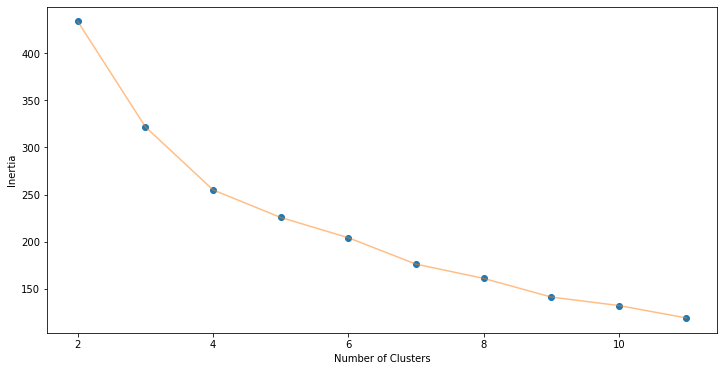

In [13]:
# elbow method를 통해 군집의 개수 결정
def change_n_clusters(n_clusters, data):
    sum_of_squared_distance = []
    for n_cluster in n_clusters:
        kmeans = KMeans(n_clusters=n_cluster)
        kmeans.fit(data)
        sum_of_squared_distance.append(kmeans.inertia_)
        
    plt.figure(1 , figsize = (12, 6))
    plt.plot(n_clusters , sum_of_squared_distance , 'o')
    plt.plot(n_clusters , sum_of_squared_distance , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')

change_n_clusters([2,3,4,5,6,7,8,9,10,11], df.iloc[:,1:])

최적의 군집 수 k = 4로 결정했습니다.

In [14]:
kmeans = KMeans(n_clusters=4, random_state = 2)
km_cluster = kmeans.fit_predict(df.iloc[:,1:])

In [15]:
df_clust = df.copy()
df_clust['km_cluster'] = km_cluster

In [16]:
eda_df = eda_df.merge(df_clust[['num','km_cluster']], on = 'num', how = 'left')

어느 정도 비슷한 전력 사용 양상을 보이는 건물끼리 군집화 된 것으로 보입니다. 요약해보자면,

* cluster 0 : 야간과 주간 전력소모 차이는 뚜렷하지만, 평일 주말 관계없이 전력소모가 일정하거나 주말 전력소요가 조금 더 높은 건물(식당, 상점, 카페)
* cluster 1 : 출근 전 시간대에 전력소모가 매우 낮고, 저녁이 될 수록 전력소모가 커짐(산업시설?)
* cluster 2 : 평일보다 주말에 전력소모가 크고, 낮보다 밤에 전력소모가 큰 건물(유흥시설, 주점)
* cluster 3 : 평일 주간에 전력소모가 크고, 평일야간이나 주말에는 전력소모가 작은 건물(사무실, 학교)

위와 같이 정리해볼 수 있습니다.

In [17]:
# dictionary mapping cluster and building
match = df_clust[['num','km_cluster']]
clust_to_num = {0:[],1:[],2:[],3:[]}
for i in range(60):
    c = match.iloc[i,1]
    clust_to_num[c].append(i+1)

### Cluster analysis
군집별로 건물들을 나눈 뒤 시각화 함으로써, 각 군집 별 건물 전력소요에 대한 인사이트를 얻어 보겠습니다.

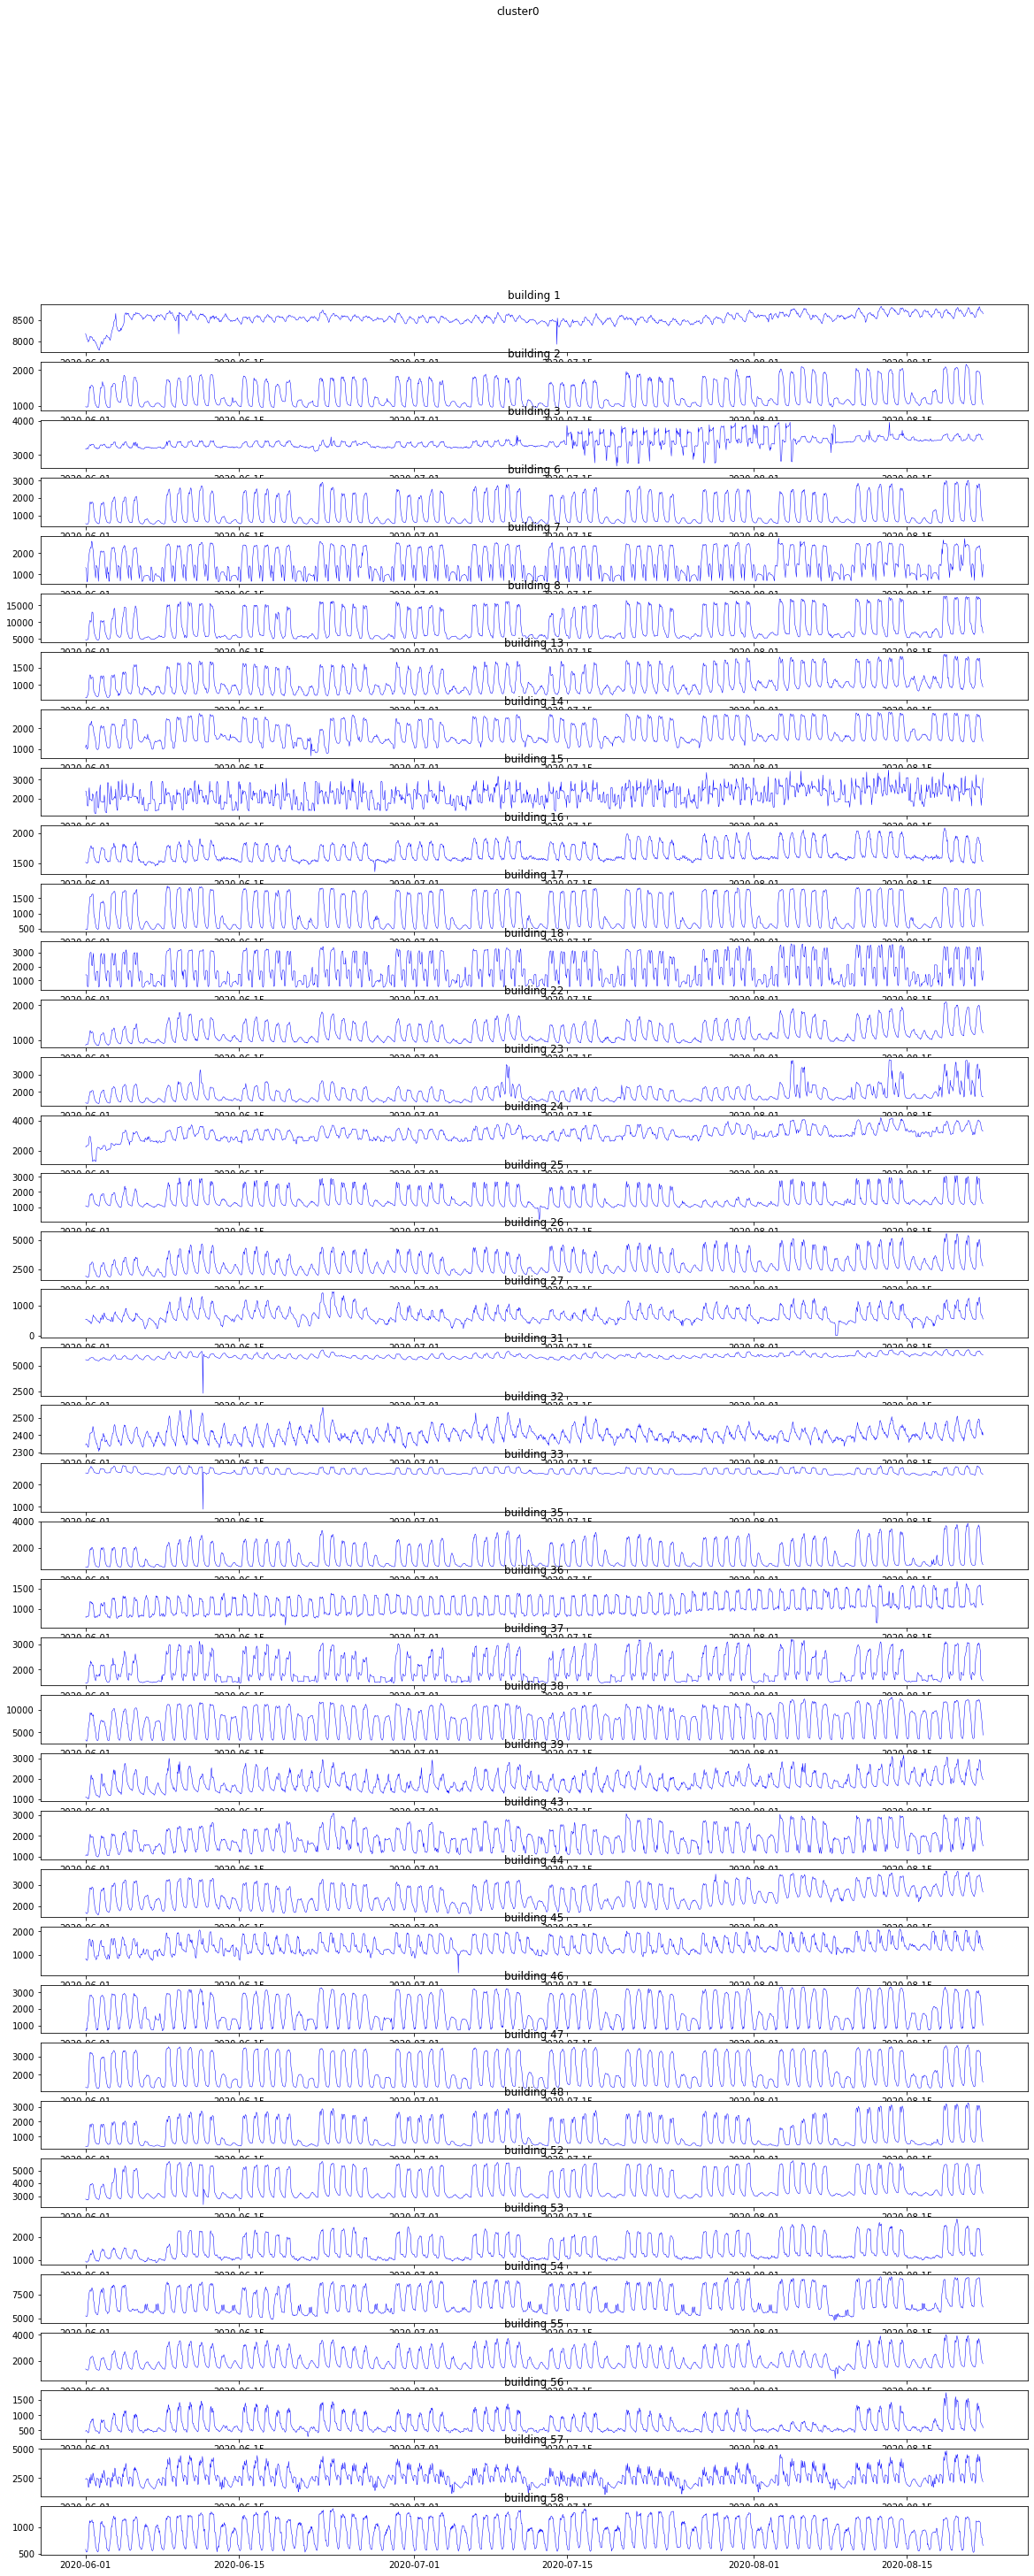

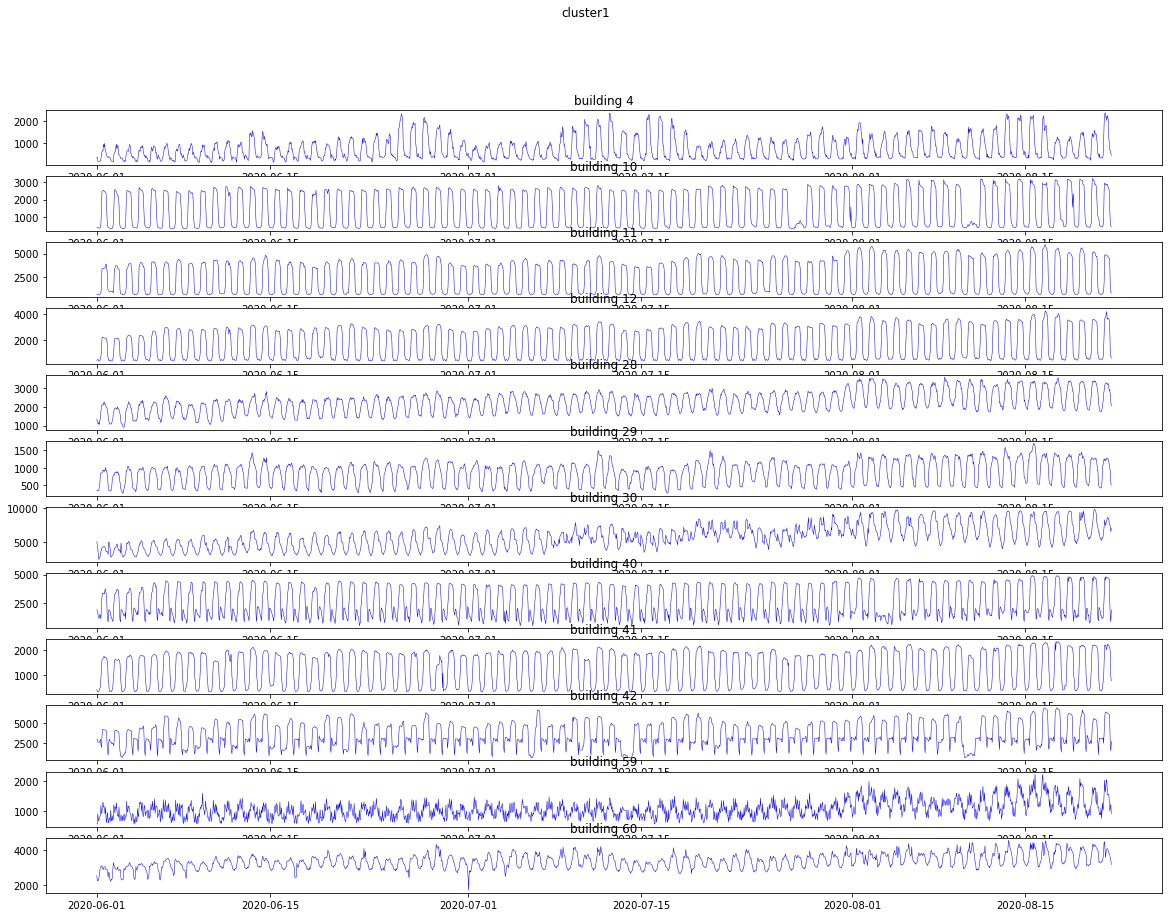

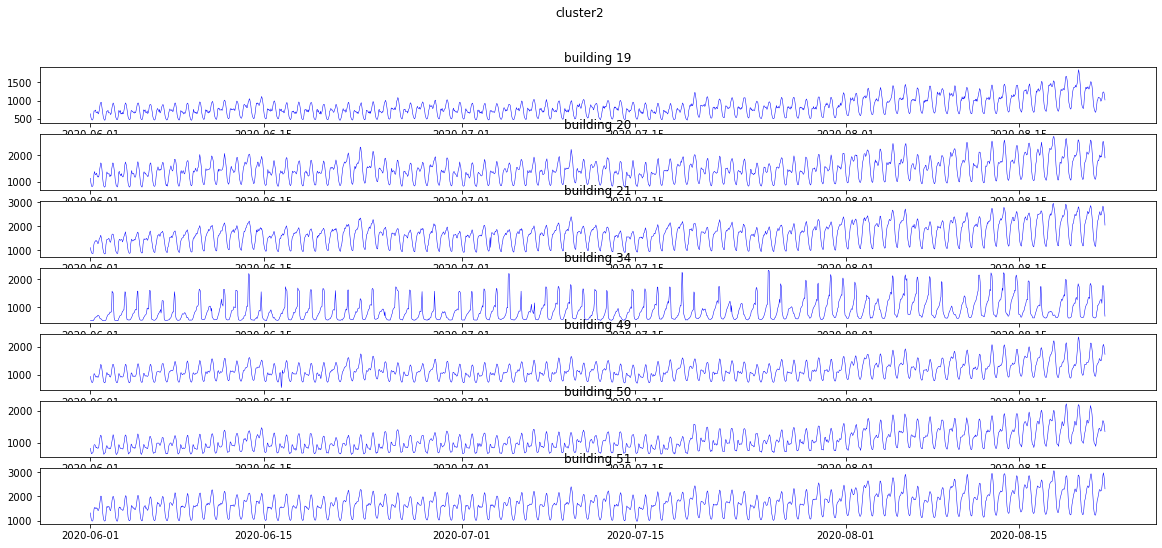

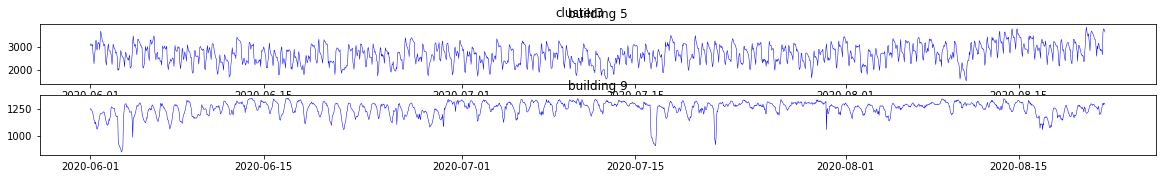

In [18]:
# linplot(energy usage of each building ~ cluster, datetime)
for c in range(4):
    temp_1 = eda_df[eda_df.km_cluster == c]
    nums = np.unique(temp_1.num)
    n_nums = len(nums)
    fig = plt.figure(figsize = (20, 1.2*n_nums))
    plt.suptitle(f'cluster{c}')
    for i, num in enumerate(nums):
        temp_2 = temp_1[temp_1.num == num]
        plt.subplot(n_nums,1, i+1)
        sns.lineplot(data = temp_2, x= 'datetime', y = 'target', linewidth = 0.5, color = 'blue')
        plt.title(f'building {num}')
        plt.ylabel('')
        plt.xlabel('')

우선, lineplot을 통해, 요일과 시간보다는 날짜에 초점을 맞추어 분석해보겠습니다.

1. cluster 0 : 낮과 밤에 따라서 전력사용량이 증가 감소를 반복하는 경향성이 보입니다.
    * 건물 4의 경우, 불분명한 원인으로 인해 특정 주기에 낮 전력 소요가 높아지는 현상이 보입니다.
    * 많은 건물들에서 시간이 지남에 따라 전력소요가 증가하는 양상을 보입니다.(냉방으로 인한 것으로 보입니다.)
2. cluster 1 : 한 군집으로 분류되긴 했으나, 공통적인 특징이 보이지 않습니다.
    * 건물 1의 경우, 초반 3일동안 전력소요가 낮게 나타납니다.
3. cluster 2 : 공통적으로 더위가 심해질수록 전력사용량이 점진적으로 증가합니다.
4. cluster 3 : 평일과 주말이 구분되는 양상을 보입니다. 이 군집에 속한 건물들은 공통적으로 대체공휴일(8.17)에도 전력소요가 낮게 나타납니다. 사무실과 학교 같은 *일터* 라는 추측에 확신을 가질 수 있습니다.
    * 건물 3의 경우, 7.15-8.4 일동안 비정상적인 전력소요 양상이 보입니다.
    * 건물 23의 경우, 8.4일부터 전력소요의 양상이 바뀝니다.
    * 이 군집에 속한 대부분의 건물들에서, 점심시간(11-12시)에 전력소요가 소폭 감소하는 모습도 보입니다.

## 2.3. Energy usage of each building in relation to weather

지금까지 분석했던 weekday나 hour과 관련된 변수들은 하루 내에서 전력 사용량의 시간 단위 변화를 설명할 수 있다면, 기상 정보는 전력 사용량의 추세를 설명할 수 있습니다.

### Temperature

기온상승에 따라 전력소요가 커진다는 것은, 냉방시설 전력소요가 중요한 건물임을 의미합니다.
* cluster 0과 2에 속하는 건물들은 building 4를 제외하고는 기온상승에 따라 전력소요가 커집니다.(소비공간일 가능성이 높습니다.)
* cluster 3에 속하는 건물들에서도 기온상승에 따라 전력소요가 커지는 경향성이 약하게나마 보입니다.
* cluster 1에 속하는 건물들은 building 9를 제외하고는 기온상승에 따라 전력소요가 커지는 경향성이 약하게나마 보입니다. 

그렇다면,비전기냉방설비를 보유한 건물은 기온이 상승함에도 불구하고 전력소요가 비교적 일정할까요? 확인해 보겠습니다.

비전기냉방시설이 있다고 해서, 기온 상승에도 불구하고 전력소요가 일정하게 유지되는 경향성은 보이지 않으므로 

비전기냉방시설 보유 여부는 전력소요와 크게 관련이 없어 보입니다.
  

지금까지의 분석을 통해, 건물 cluster 0,2,3에서 일일 평균 기온이 일일 평균 전력 사용량에 영향을 준다는 점은 알 수 있었습니다. 

하지만 기온(temperature) 변수는 설명력이 다소 부족합니다. 냉방 전력소요의 측면에서 보았을 때, 전력 사용량은 기온이 변함에 따라 즉각적으로 변화하진 않기 때문입니다. 

냉방전력소요와 관련하여, *CDH(cooling degree hour, 냉방도일)* 이라는 개념을 조금 변형하여 적용해 보았습니다. 냉방 기준온도(26도)보다 높은 시점에서 해당 시점의 온도와 기준온도의 차를 적산하여 구할 수 있습니다. 이렇게 구해진 CDH 라는 변수는, 기온보다 냉방 수요에 대한 설명력이 높습니다. 결과를 시각화 해 보겠습니다.  

In [19]:
# CDH feature추가
def CDH(xs):
    ys = []
    for i in range(len(xs)):
        if i < 11:
            ys.append(np.sum(xs[:(i+1)]-26))
        else:
            ys.append(np.sum(xs[(i-11):(i+1)]-26))
    return np.array(ys)

cdhs = np.array([])
for num in range(1,61,1):
    temp = eda_df[eda_df['num'] == num]
    cdh = CDH(temp['temperature'].values)
    cdhs = np.concatenate([cdhs, cdh])
eda_df['CDH'] = cdhs

* cluster 0,2,3에 속한 건물들에서는 일평균 CDH와 일평균 전력소요 간에 유의미한 관계가 보입니다.

다음으로 확인해 볼 것은, **불쾌지수** 입니다. 불쾌지수를 계산하여, 쾌적/다소 불쾌/불쾌/ 매우 불쾌 4개의 카테고리로 나눈 뒤, 불쾌지수 정도에 따른 전력사용량 분포를 파악 해 보겠습니다.

In [20]:
eda_df['THI'] = 9/5*eda_df['temperature'] - 0.55*(1-eda_df['humidity']/100)*(9/5*eda_df['temperature']-26)+32
eda_df['THI_cat'] = pd.cut(eda_df['THI'], bins = [0, 68, 75, 80, 200], labels = [1,2,3,4])



* 건물 9를 제외하고는 불쾌지수에 따라 전력 소모가 증가하는 양상을 보입니다.
* 많은 건물에서 불쾌지수가 4(매우 불쾌)일 때, 전력 소모가 급증합니다.

전반적으로, temperature, THI(불쾌지수), CDH(냉방도일)의 평균값이 일일 에너지 사용량 평균치와 높은 상관관계를 보이고 있습니다. 지금까지의 시각화 결과, 기상 관련 변수들은 하루 동안의 에너지 증감 추세보다는 장기적인 추세를 잘 반영하므로, feature에 추가할 수 있습니다.

# 3. Data Preprocessing and Cross validation

EDA 과정에서 발견한 인사이트를 바탕으로, 여러 feature들을 만들어 보았습니다. 기본적으로 각 건물별로 모델을 생성하였습니다.
* mean_temperature, mean_THI, mean_CDH, date_num 등의 일별 feature를 추가하였습니다.
* cluster별로, working time boolean feature를 추가해 보았습니다. cluster 0의 경우 낮 시간대에, cluster2의 경우 밤 시간대에, cluster 3의 경우 평일 낮 시간대에 전력 사용량이 높게 나타나므로, 해당 시간대에 1의 값을 갖는 feature를 추가해 보았습니다.

In [21]:
# function for feature engineering
def CDH(xs):
    ys = []
    for i in range(len(xs)):
        if i < 11:
            ys.append(np.sum(xs[:(i+1)]-26))
        else:
            ys.append(np.sum(xs[(i-11):(i+1)]-26))
    return np.array(ys)

# data preprocessing function for testset
def train_preprocess(train):
    X_train = train.copy()
    X_train['datetime'] = pd.to_datetime(X_train['datetime'])
    X_train['hour'] = X_train['datetime'].dt.hour
    X_train['month'] = X_train['datetime'].dt.month
    X_train['day'] = X_train['datetime'].dt.day
    X_train['date'] = X_train['datetime'].dt.date
    X_train['weekday'] = X_train['datetime'].dt.weekday
    ## one hot encoding for weekday and hour
    X_train = pd.concat([X_train, pd.get_dummies(X_train['weekday'], prefix ='weekday')], axis=1)
    X_train = pd.concat([X_train, pd.get_dummies(X_train['hour'], prefix ='hour')], axis=1)
    ## daily minimum temperature
    X_train = X_train.merge(X_train.groupby(['num','date'])['temperature'].min().reset_index().rename(columns = {'temperature':'min_temperature'}), on = ['num','date'], how = 'left')
    ## THI
    X_train['THI'] = 9/5*X_train['temperature'] - 0.55*(1-X_train['humidity']/100)*(9/5*X_train['temperature']-26)+32
    ## mean_THI
    X_train = X_train.merge(X_train.groupby(['num','date'])['THI'].mean().reset_index().rename(columns = {'THI':'mean_THI'}), on = ['num','date'], how = 'left')
    ## CDH
    cdhs = np.array([])
    for num in range(1,61,1):
        temp = X_train[X_train['num'] == num]
        cdh = CDH(temp['temperature'].values)
        cdhs = np.concatenate([cdhs, cdh])
    X_train['CDH'] = cdhs
    ## mean_CDH
    X_train = X_train.merge(X_train.groupby(['num','date'])['CDH'].mean().reset_index().rename(columns = {'CDH':'mean_CDH'}), on = ['num','date'], how = 'left')  
    ## date to numeric
    X_train['date_num'] = X_train['month'] + X_train['day']/31
    # split each building
    X_trains = [X_train[X_train.num == num] for num in range(1,61,1)]
    ## THI_category
    THI_nums = list(range(1,9))+list(range(10,61))
    for num in THI_nums:
        temp_df = X_trains[num-1]
        temp_df['THI_1'] = (temp_df['THI'] < 68).astype(int)
        temp_df['THI_2'] = ((temp_df['THI'] >= 68)&(temp_df['THI'] < 75)).astype(int)
        temp_df['THI_3'] = ((temp_df['THI'] >= 75)&(temp_df['THI'] < 80)).astype(int)
        temp_df['THI_4'] = (temp_df['THI'] >= 80).astype(int)
        X_trains[num-1] = temp_df
    ## feature engineering on each cluster
    for num in clust_to_num[0]:
        temp_df = X_trains[num-1]
        temp_df['working_time'] = ((temp_df['hour'].isin([8,9,10,11,12,13,14,15,16,17,18,19]))).astype(int)
        X_trains[num-1] = temp_df
    for num in clust_to_num[2]:
        temp_df = X_trains[num-1]
        temp_df['working_time'] = ((temp_df['hour'].isin([18,19,20,21,22]))).astype(int)
        X_trains[num-1] = temp_df
    for num in clust_to_num[3]:
        temp_df = X_trains[num-1]
        temp_df['working_time'] = ((temp_df['hour'].isin([8,9,10,11,12,13,14,15,16,17,18,19]))&(temp_df['weekday'].isin([0,1,2,3,4]))).astype(int)
        temp_df['lunch_time'] = ((temp_df['hour'].isin([11,12]))&(temp_df['weekday'].isin([0,1,2,3,4]))).astype(int)
        X_trains[num-1] = temp_df
    
    y_trains = [df['target'].values for df in X_trains]
    X_trains = [df.drop('target', axis = 1) for df in X_trains]
    # drop unnecessary columns
    X_trains = [df.drop(['num', 'datetime', 'hour', 'month', 'day', 'date', 'weekday','solar_flag','nelec_cool_flag'], axis=1).reset_index().drop('index', axis=1) for df in X_trains]
    # standard scaling on numerical features
    num_features = ['temperature', 'windspeed', 'humidity', 'precipitation', 'insolation','min_temperature','THI','mean_THI','CDH','mean_CDH','date_num']
    means = []
    stds = []
    for i, df in enumerate(X_trains):
        means.append(df.loc[:,num_features].mean(axis=0))
        stds.append(df.loc[:,num_features].std(axis=0))
        df.loc[:,num_features] = (df.loc[:,num_features] - df.loc[:,num_features].mean(axis=0))/df.loc[:,num_features].std(axis=0)
        X_trains[i] = df
    return X_trains, y_trains, means, stds

# data preprocessing function for testset
def test_preprocess(test, means, stds):
    X_train = test.copy()
    X_train = X_train.interpolate()
    
    X_train['datetime'] = pd.to_datetime(X_train['datetime'])
    X_train['hour'] = X_train['datetime'].dt.hour
    X_train['month'] = X_train['datetime'].dt.month
    X_train['day'] = X_train['datetime'].dt.day
    X_train['date'] = X_train['datetime'].dt.date
    X_train['weekday'] = X_train['datetime'].dt.weekday
    ## one hot encoding for weekday and hour
    X_train = pd.concat([X_train, pd.get_dummies(X_train['weekday'], prefix ='weekday')], axis=1)
    X_train = pd.concat([X_train, pd.get_dummies(X_train['hour'], prefix ='hour')], axis=1)
    ## daily minimum temperature
    X_train = X_train.merge(X_train.groupby(['num','date'])['temperature'].min().reset_index().rename(columns = {'temperature':'min_temperature'}), on = ['num','date'], how = 'left')
    ## THI
    X_train['THI'] = 9/5*X_train['temperature'] - 0.55*(1-X_train['humidity']/100)*(9/5*X_train['temperature']-26)+32
    ## mean_THI
    X_train = X_train.merge(X_train.groupby(['num','date'])['THI'].mean().reset_index().rename(columns = {'THI':'mean_THI'}), on = ['num','date'], how = 'left')
    ## CDH
    cdhs = np.array([])
    for num in range(1,61,1):
        temp = X_train[X_train['num'] == num]
        cdh = CDH(temp['temperature'].values)
        cdhs = np.concatenate([cdhs, cdh])
    X_train['CDH'] = cdhs
    ## mean_CDH
    X_train = X_train.merge(X_train.groupby(['num','date'])['CDH'].mean().reset_index().rename(columns = {'CDH':'mean_CDH'}), on = ['num','date'], how = 'left')  
    ## date to numeric
    X_train['date_num'] = X_train['month'] + X_train['day']/31
    
    X_trains = [X_train[X_train.num == num] for num in range(1,61,1)]
    ## THI_category
    THI_nums = list(range(1,9))+list(range(10,61))
    for num in THI_nums:
        temp_df = X_trains[num-1]
        temp_df['THI_1'] = (temp_df['THI'] < 68).astype(int)
        temp_df['THI_2'] = ((temp_df['THI'] >= 68)&(temp_df['THI'] < 75)).astype(int)
        temp_df['THI_3'] = ((temp_df['THI'] >= 75)&(temp_df['THI'] < 80)).astype(int)
        temp_df['THI_4'] = (temp_df['THI'] >= 80).astype(int)
        X_trains[num-1] = temp_df
    ## feature engineering on each cluster
    for num in clust_to_num[0]:
        temp_df = X_trains[num-1]
        temp_df['working_time'] = ((temp_df['hour'].isin([8,9,10,11,12,13,14,15,16,17,18,19]))).astype(int)
        X_trains[num-1] = temp_df
    for num in clust_to_num[2]:
        temp_df = X_trains[num-1]
        temp_df['working_time'] = ((temp_df['hour'].isin([18,19,20,21,22]))).astype(int)
        X_trains[num-1] = temp_df
    for num in clust_to_num[3]:
        temp_df = X_trains[num-1]
        temp_df['working_time'] = ((temp_df['hour'].isin([8,9,10,11,12,13,14,15,16,17,18,19]))&(temp_df['weekday'].isin([0,1,2,3,4]))).astype(int)
        temp_df['lunch_time'] = ((temp_df['hour'].isin([11,12]))&(temp_df['weekday'].isin([0,1,2,3,4]))).astype(int)
        X_trains[num-1] = temp_df
    # drop unnecessary columns
    X_trains = [df.drop(['num', 'datetime', 'hour', 'month', 'day', 'date', 'weekday','solar_flag','nelec_cool_flag'], axis=1).reset_index().drop('index', axis=1) for df in X_trains]
    # standard scaling on numerical features
    num_features = ['temperature', 'windspeed', 'humidity', 'precipitation', 'insolation','min_temperature','THI', 'mean_THI','CDH','mean_CDH', 'date_num']
    for i, (df, mean, std) in enumerate(zip(X_trains, means, stds)):
        df.loc[:,num_features] = (df.loc[:,num_features] - mean) / std
        X_trains[i] = df
    return X_trains

In [22]:
X_trains, y_trains, means, stds = train_preprocess(train_df)
X_tests = test_preprocess(test_df, means, stds)

# 4. Modeling

## 4.1. Cross validation utils and metric

k-fold CV부터 Error analysis까지 쉽게 할 수 있는 CV class를 만들어 보았습니다.

In [23]:
# metric
def SMAPE(true, pred):
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred)))*100

# customized k-fold CV class for scikit-learn model
class CV_sklearn():
    def __init__(self, models, n_folds = 8):
        '''
        models : list of 8 models
        n_folds : int
        '''
        self.models = models
        self.n_folds = n_folds
    
    def cv_score(self, X_trains, y_trains, verbose = 0, perm_imp = False, feat_imp = False):
        '''
        X_trains : list of 60 dataframes
        y_trains : list of 60 series
        '''
        trues = [[],[],[],[],[],[],[],[]]
        preds = [[],[],[],[],[],[],[],[]]
        permutation_importances = [[],[],[],[],[],[],[],[]]
        feature_importances = [[],[],[],[],[],[],[],[]]
        # for each building
        for i, (X_train, y_train) in enumerate(zip(X_trains, y_trains)):
            kfold = KFold(n_splits=8, shuffle = False)
            # for each fold
            for j, (tr_idx, val_idx) in enumerate(kfold.split(X_train, y_train)):
                X_tr, X_val = X_train.iloc[tr_idx,:], X_train.iloc[val_idx,:]
                y_tr, y_val = y_train[tr_idx], y_train[val_idx]
                # fit model on each fold
                temp_model = self.models[j][i]
                temp_model.fit(X_tr, y_tr)
                if perm_imp:
                    r = permutation_importance(temp_model, X_val, y_val, n_repeats=10, scoring=smape, random_state=2)
                    permutation_importances[j].append(r['importances_mean'])
                if feat_imp:
                    feature_importances[j].append(temp_model.feature_importances_)
                self.models[j][i] = temp_model
                pred = temp_model.predict(X_val)
                true = y_val
                preds[j].append(pred)
                trues[j].append(true)
                
            if (verbose == 1)&((i+1)%5==0) :
                print(f'{i+1}th model complete')
        scores = []
        for true, pred in zip(trues, preds):
            true_f = np.concatenate(true)
            pred_f = np.concatenate(pred)
            scores.append(SMAPE(true_f, pred_f))
        self.trues = trues
        self.preds = preds
        self.permutation_importances = permutation_importances
        self.feature_importances = feature_importances
        return scores

## 4.2. Baseline using Linear Model

간단한 linear model를 건물별로 적합 해 보겠습니다.

In [24]:
lr_models = [[LinearRegression() for i in range(60)] for j in range(8)]
cv_lr = CV_sklearn(lr_models, n_folds = 8)
scores_lr = cv_lr.cv_score(X_trains, y_trains, verbose = 1)
print(np.mean(scores_lr))

5th model complete
10th model complete
15th model complete
20th model complete
25th model complete
30th model complete
35th model complete
40th model complete
45th model complete
50th model complete
55th model complete
60th model complete
6.1334734980633545


8 fold CV score 산출 결과 4.3802 정도가 나왔습니다.

## 4.3. Error Analysis

In [25]:
# extract cross validation prediction
cv_trues = [np.concatenate([f1, f2, f3, f4, f5, f6, f7, f8]) for f1, f2, f3, f4, f5, f6, f7, f8 in zip(*cv_lr.trues)]
cv_preds = [np.concatenate([f1, f2, f3, f4, f5, f6, f7, f8]) for f1, f2, f3, f4, f5, f6, f7, f8 in zip(*cv_lr.preds)]

In [39]:
X_train

NameError: name 'X_train' is not defined

In [38]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.model_selection import StratifiedKFold

n_splits = 5
sfk = StratifiedKFold(n_splits = n_splits)

y_pred = np.zeros(len(X_tests))

# train데이터셋에서 건물의 비율을 동일하게하기 위해 StratifiedKFold 사용
for tr_idx, val_idx in sfk.split(X_train, X_train['num']):      
    X_train = X_train.iloc[tr_idx, :]
    y_train = y_train[tr_idx]

    X_val = X_train.iloc[val_idx, :]
    y_val = y_train[val_idx]

    lgbm = LGBMRegressor(n_estimators = 10000, learning_rate= 0.1,objective = 'mse')
    lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric= 'rmse', early_stopping_rounds= 50,verbose = 100)
    y_pred += lgbm.predict(X_tests) / n_splits

NameError: name 'X' is not defined

In [29]:
submission['answer']=valid_pred_array.reshape([-1,1])
submission

NameError: name 'prediction' is not defined

---

이 노트북은 계속해서 업데이트 할 예정입니다. 

지금까지 분석을 해 보면서 느낀 것은, 사용 가능한 데이터가 조금 아쉽다는 것입니다. 주어진 데이터는 시간 데이터, 건물 정보 데이터와 그리고 기후 데이터로  나눌 수 있습니다. 이 중 가장 중요한 것은 건물 정보 데이터라고 생각하는데, 이번 competition에서 주어진 건물 정보는 **건물 번호/비전기냉방설비여부/태양광설비여부** 가 전부입니다.

여러 datetime관련 feature들을 만들어내서 각 건물들이 어떤 건물인지 추론하는 것도 즐거운 일이지만, 만약 **건물 정보(건물의위치/ 용도 등)** 가 주어졌다면 더욱 정밀한 모델을 만들 수 있지 않나 하는 아쉬움이 듭니다.